# Fetch Daily Volume

Goals:
* Get daily volume from the graph


In [1]:
import os
import asyncio
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from decimal import Decimal


In [2]:
## constants
INFURA_KEY = os.getenv('INFURA_KEY')

# mainnet
FUTURES_ENDPOINT = 'https://api.thegraph.com/subgraphs/name/kwenta/optimism-main'
RPC_ENDPOINT = f'https://optimism-mainnet.infura.io/v3/{INFURA_KEY}'

# testnet
# FUTURES_ENDPOINT = 'https://api.thegraph.com/subgraphs/name/kwenta/optimism-kovan-main' 
# RPC_ENDPOINT = f'https://optimism-kovan.infura.io/v3/{INFURA_KEY}'


In [3]:
# functions
convertDecimals = lambda x: Decimal(x) / Decimal(10**18)

def clean_df(df, decimal_cols):
    for col in decimal_cols:
        if col in df.columns:
            df[col] = df[col].apply(convertDecimals)
        else:
            print(f"{col} not in DataFrame")
    return df

async def run_query(query, params, endpoint=FUTURES_ENDPOINT):
    transport = AIOHTTPTransport(url=endpoint)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:

        # Execute single query
        query = query

        result = await session.execute(query, variable_values=params)
        return result


async def run_recursive_query(query, params, accessor, endpoint=FUTURES_ENDPOINT):
  transport = AIOHTTPTransport(url=endpoint)

  async with Client(
      transport=transport,
      fetch_schema_from_transport=True,
  ) as session:
    done_fetching = False
    all_results = []
    while not done_fetching:
      result = await session.execute(query, variable_values=params)
      if len(result[accessor]) > 0:
        all_results.extend(result[accessor])
        params['last_id'] = all_results[-1]['id']
      else:
        done_fetching = True

    return all_results


In [4]:
# queries
stats = gql("""
query futuresOneMinStats(
  $last_id: ID!
) {
  futuresOneMinStats(
    first: 1000
    where: {
      timestamp_gt: 1654063200
      id_gt: $last_id
    }
  ) {
    id
    trades
    volume
    timestamp
  }
}""")


### Query daily volume

In [5]:
df_stats = pd.DataFrame()

params = {'last_id': ''}

decimal_cols = [
    'volume'
]

stats_response = await run_recursive_query(stats, params, 'futuresOneMinStats')
df_stats = pd.DataFrame(stats_response)
df_stats = clean_df(df_stats, decimal_cols)

# summarize the data
df_stats['day'] = pd.to_datetime(df_stats['timestamp'], unit='s')
df_stats['day'] = df_stats['day'].apply(lambda x: x.date())

df_volume = df_stats.groupby('day')['volume'].sum()
df_volume


ok...
fetching 
fetching 1654277700
fetching 1654535460
fetching 1654800000
fetching 1655042040
fetching 1655178480
fetching 1655343180
fetching 1655582340
fetching 1655825220
fetching 1656078840
fetching 1656381000
fetching 1656646320
fetching 1657056120
fetching 1657385640
fetching 1657721280
fetching 1657996200
fetching 1658234280
fetching 1658449500
fetching 1658792940
fetching 1659018180


day
2022-06-01     5805818.666395455692430594
2022-06-02     5581283.675048302867419391
2022-06-03     5454915.965868676221342769
2022-06-04     2341713.103448835788525682
2022-06-05     2420691.249477810039151719
2022-06-06     7957359.435529182672276288
2022-06-07     7123473.535626452776429695
2022-06-08     5417034.222377246324517905
2022-06-09     3392732.627633440147104196
2022-06-10    19830760.722001656848846038
2022-06-11     9734130.221039644222122001
2022-06-12    43540213.723324907337442384
2022-06-13    86140108.654524810586235995
2022-06-14    69862781.509178710020246702
2022-06-15    46270287.595584620624693165
2022-06-16    24533158.144115998105277064
2022-06-17    11237897.766203063392255967
2022-06-18    20696277.960244934860456878
2022-06-19    12531591.932537588047601717
2022-06-20    13703069.957224599009750856
2022-06-21    12633487.822056834885395382
2022-06-22     8164731.866626073605849659
2022-06-23     5273897.837684490414573276
2022-06-24     8139107.1351858

In [12]:
df_volume = df_volume.reset_index()
df_volume['volume'] = df_volume['volume'].astype(float)
df_volume

,day,volume
0,2022-06-01,5.805819e+06
1,2022-06-02,5.581284e+06
2,2022-06-03,5.454916e+06
3,2022-06-04,2.341713e+06
4,2022-06-05,2.420691e+06
5,2022-06-06,7.957359e+06
6,2022-06-07,7.123474e+06
7,2022-06-08,5.417034e+06
8,2022-06-09,3.392733e+06
9,2022-06-10,1.983076e+07


<AxesSubplot:xlabel='day'>

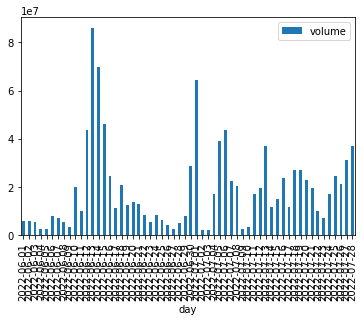

In [14]:
df_volume.reset_index().plot(x='day', y='volume', kind='bar')

In [21]:
pd.options.display.float_format = '{:.2f}'.format
print(df_volume.tail(60))

           day      volume
0   2022-06-01  5805818.67
1   2022-06-02  5581283.68
2   2022-06-03  5454915.97
3   2022-06-04  2341713.10
4   2022-06-05  2420691.25
5   2022-06-06  7957359.44
6   2022-06-07  7123473.54
7   2022-06-08  5417034.22
8   2022-06-09  3392732.63
9   2022-06-10 19830760.72
10  2022-06-11  9734130.22
11  2022-06-12 43540213.72
12  2022-06-13 86140108.65
13  2022-06-14 69862781.51
14  2022-06-15 46270287.60
15  2022-06-16 24533158.14
16  2022-06-17 11237897.77
17  2022-06-18 20696277.96
18  2022-06-19 12531591.93
19  2022-06-20 13703069.96
20  2022-06-21 12633487.82
21  2022-06-22  8164731.87
22  2022-06-23  5273897.84
23  2022-06-24  8139107.14
24  2022-06-25  6202194.70
25  2022-06-26  4267424.87
26  2022-06-27  2603462.05
27  2022-06-28  4870999.49
28  2022-06-29  7714020.99
29  2022-06-30 28617936.01
30  2022-07-01 64236666.33
31  2022-07-02  2175317.87
32  2022-07-03  2169609.15
33  2022-07-04 17025535.24
34  2022-07-05 39011630.43
35  2022-07-06 43670956.50
3